## Ucitavanje podataka

In [21]:
import pandas as pd 
import numpy as np

df = pd.read_csv(
        'elektroprecisceno.csv',
         index_col=0
     )
df

,godine,stariji,Pol,indikacija:,ukupno,trajanje,frekvenca,Blok,dimenzija,EDD,...,Sotalol,Digoksin,ASA,OAKT,Plavix,Statin,Implantiran,Vreme,"sinhroni,",Elektrokonverzija
Broj,,,,,,,,,,,,,,,,,,,,,
1,78,1,1,1,5,5,0,3,42,56,...,0,0,0,2,0,0,1,2,2,True
2,61,0,1,2,24,1,7,0,42,59,...,0,0,0,2,0,0,0,-1,2,True
3,65,1,1,1,4,4,0,3,47,55,...,0,0,0,2,0,0,1,3,2,True
4,64,0,1,1,288,2,7,0,50,50,...,0,0,0,2,0,0,0,-1,2,True
5,65,1,2,1,48,3,9,0,49,61,...,0,0,0,2,0,1,0,-1,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,61,0,1,2,2,2,0,3,36,54,...,0,0,0,2,0,0,1,2,2,True
647,58,0,1,2,12,2,0,3,45,57,...,0,0,0,3,0,1,1,2,2,True
648,72,1,2,1,20,20,6,0,43,66,...,0,1,0,3,0,0,0,-1,2,True


## Podela podataka na trening i test

In [13]:
from sklearn.model_selection import train_test_split

X = df.iloc[:,:-1]
y = df.iloc[:,-1] 

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0, stratify=y, test_size=0.35)

## Kreiranje i primena stabla odlucivanja

Klase ciljnog atributa Elektrokonverzije su nebalansirane, True klasa je zastupljena u 130 slucajeva, dok je False klasa zastupljena u 17 slucajeva. Zbog toga je pri kreiranju stabla dodat argument class_weight='balanced', a najbolje stablo dobijeno je sa velicinom test skupa podesenom na 35% velicine pocetnog skupa.

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score

clf = DecisionTreeClassifier(random_state=0, class_weight='balanced')
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print(f"Balansirana tacnost stabla: {balanced_accuracy_score(y_test,pred)}")

[[ 2  4]
 [ 3 43]]
              precision    recall  f1-score   support

       False       0.40      0.33      0.36         6
        True       0.91      0.93      0.92        46

    accuracy                           0.87        52
   macro avg       0.66      0.63      0.64        52
weighted avg       0.86      0.87      0.86        52

Balansirana tacnost stabla: 0.6340579710144928


## ROC kriva modela

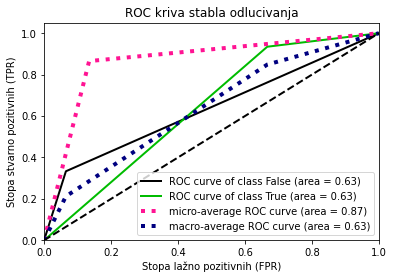

In [15]:
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, auc
import scikitplot as skplt

y_probas = clf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas)

plt.xlabel('Stopa lažno pozitivnih (FPR)')
plt.ylabel('Stopa stvarno pozitivnih (TPR)')

plt.title('ROC kriva stabla odlucivanja')
plt.legend(loc="lower right")

plt.show()

## Skracivanje stabla
Predstavljeno stablo je u potpunosti prilagodjeno trening podacima i nema dovoljno dobre performanse sa test podacima, pa zbog toga treba pokusati sa odsecanjem delova stabla. <br>
Za to je koriscena tehnika odsecanja pomocu parametra ccp_alpha, gde se za vece vrednosti parametra odseca vise cvorova.
Za razlicite vrednosti parametra ispitan je kvalitet dobijenog stabla (balanced_accuracy_score, f1_score, recall su korisceni za meru kvaliteta).  <br>
Medjutim, za svaku od mera, kao i za balanced_accuracy_score prikazanu na grafiku, najbolji kvalitet se dobija za alpha=0.0, sto znaci da se odsecanjem stabla ne dobijaju bolji rezultati za test podatke.

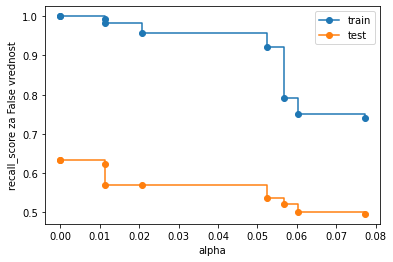

In [16]:
ccp_alphas = clf.cost_complexity_pruning_path(X_train, y_train).ccp_alphas[:-1]

clfs = []
for ccp_alpha in ccp_alphas:
    clf_pruned = DecisionTreeClassifier(random_state = 0, class_weight='balanced', ccp_alpha = ccp_alpha)
    clf_pruned.fit(X_train, y_train)
    clfs.append(clf_pruned)

train_scores = [balanced_accuracy_score(y_train,clf_pruned.predict(X_train)) for clf_pruned in clfs]
test_scores = [balanced_accuracy_score(y_test,clf_pruned.predict(X_test)) for clf_pruned in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("recall_score za False vrednost")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

## Ispitivanje povezanost i vaznsoti atributa $\tiny \text{(dobijene vrednosti bice koriscene kroz kasnije metode. )}$

In [17]:
from sklearn.inspection import permutation_importance

importances = sorted(zip(clf.feature_importances_,X.columns), reverse=True)
for importance, column in importances:
    if importance >= 1e-06:
        print(f'{column} : {importance:.6f}')

frekvenca : 0.396828
godine : 0.177675
ukupno : 0.160366
EF : 0.104846
dosadašnje : 0.091570
MR : 0.046186
HLP : 0.022529


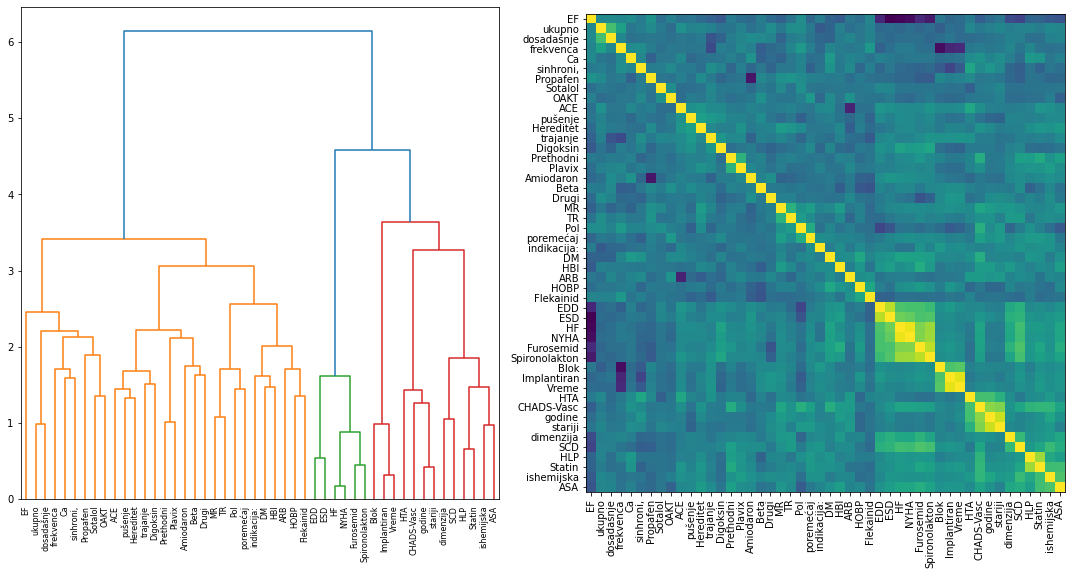

In [18]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=X.columns.tolist(), ax=ax1)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

## Primena sume za klasifikaciju $\tiny \text{(dobija se model slican prethodnom, ali ne bolji)}$

In [20]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0,
                             bootstrap=True, 
                             n_estimators=2, 
                             class_weight='balanced')
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[ 2  4]
 [ 7 39]]
              precision    recall  f1-score   support

       False       0.22      0.33      0.27         6
        True       0.91      0.85      0.88        46

    accuracy                           0.79        52
   macro avg       0.56      0.59      0.57        52
weighted avg       0.83      0.79      0.81        52

